# Code ``ex0.py``

In [119]:
from dolfin import *
from mshr import *
import os

# i. Geometry definition
Lx = 2
Ly = 2
corner1 = Point(0,0)
corner2 = Point(Lx,Ly)
center = Point(Lx/2,Ly/2)
radius = 0.25
domain = Rectangle(corner1, corner2)
domain.set_subdomain(1, Circle(center,radius))

class Inclusion(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt ( ( x[0] - Lx/2 ) ** 2 + ( x[1] - Ly/2 ) ** 2 )
        return ( r < radius * 1.001 )

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], 0.0) )

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], Lx) )

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], 0.0) )

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], Ly) )

class Hole(SubDomain):
   def __init__(self,xc,yc,R):
      self.xc = xc
      self.yc = yc
      self.R = R
      SubDomain.__init__(self) # Call base class constructor!
   def inside (self, x, on_boundary ):
      r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
      return ( on_boundary and ( r < self.R * 1.1 ) )

# ii. Mesh generation
subdivisions = 60
mesh = generate_mesh ( domain, subdivisions )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

# iii. Mark subdomains
mfunc = MeshFunction("size_t", mesh, mesh.topology().dim())
mfunc.set_all(1)
inclusion = Inclusion()
inclusion.mark(mfunc, 2)

# iv. Mesh transformations
scale = 0
if(scale):
    # Scale the coordinates
    x = mesh.coordinates()
    x[:,0] = x[:,0]*2
    x[:,1] = x[:,1]*4
    print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))
    
angle = 0
if(angle):
    # Rotate with respect to z-axis
    mesh.rotate(angle, 2, corner1)

# Save results for visulation in Paraview
dir_ = './results'
if not os.path.exists(dir_):
    os.mkdir(dir_)
file_pvd  = File(dir_+"/res.pvd")
file_pvd << mfunc

# v. Inspect the mesh
inspect = 0
if(inspect):    
    # Incidencies
    elems = cells(mesh)
    print("Element to node")
    for e in elems:
        incids = []
        for v in vertices(e):
            incids.append(v.index())
            
        print(e.index(), incids, e.circumradius())
            
    # Incidencies transpose
    print("Node to element")
    for v in vertices(mesh):
        conec = []
        for c in cells(v):
            conec.append(c.index())
            
        print (v.index(), conec)

# vi. Fluid Problem
fluid_problem = 1
if(fluid_problem): # Begin Stokes problem

    # New geometry: Rectangle with a hole
    centerhole = Point(Lx/4,Ly/4)
    domain = Rectangle(corner1, corner2)
    domain = domain - Circle(centerhole,0.5*radius)
    subdivisions = 50
    mesh = generate_mesh (domain, subdivisions)
    
    # Finite element spaces
    P2 = VectorElement("Lagrange", 'triangle', 2)
    P1 = FiniteElement("Lagrange", 'triangle', 1)
    TH = P2 * P1
    W = FunctionSpace(mesh, TH)

    # Define subdomain classes associated to boundaries
    inlet = Left()
    top = Top()
    outlet = Right()
    bottom = Bottom()
    hole = Hole(Lx/4,Ly/4,0.5*radius)

    # Boundary conditions
    # Inlet
    inflow = Expression(("sin(x[1]*pi/2)", "0.0"), degree=2)
    bcIn  = DirichletBC(W.sub(0), inflow, inlet)
    # No-slip (walls= top, bottom and hole)
    noslip = Constant((0, 0))
    bcnsb  = DirichletBC(W.sub(0), noslip, bottom)
    bcnst  = DirichletBC(W.sub(0), noslip, top)
    bchole = DirichletBC(W.sub(0), noslip, hole)
    
    # Variational problem
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)
    mu = Constant(1)
    a = (inner(2*mu*sym(grad(u)), grad(v)) - div(v)*p + q*div(u))*dx
    f = Constant((0, 0))
    L = inner(f, v)*dx

    # Compute solution
    w = Function(W)
    solve(a == L, w, [bcIn, bcnsb, bcnst, bchole])
   
    # Split the mixed solution using deepcopy
    # (needed for further computation on coefficient vector)
    (u, p) = w.split(True)

    # Mesh function for further integration over boundaries
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    boundaries.set_all(0)
    inlet.mark(boundaries, 1)
    outlet.mark(boundaries, 3)
    ds = Measure("ds")(subdomain_data=boundaries)
    n = FacetNormal(mesh)
    Qin  = assemble(dot(u, n)*ds(1))
    Qout = assemble(dot(u, n)*ds(3))
    print (f' Q_in = {Qin} \n Q_out = {Qout}')

    # Save results for visulation in Paraview
    u.rename("u","u")
    p.rename("p","p")
    u_pvd  = File(dir_+"/vel.pvd")
    p_pvd  = File(dir_+"/pres.pvd")
    u_pvd << u
    p_pvd << p


    |-Mesh done
    |--Number of vertices = 5733
    |--Number of cells = 11204
    |--Cell size hmax,hmin = 0.0424 0.0215
 Q_in = -1.2732395473021774 
 Q_out = 1.273239547302205


# 1. Make sure to understand the different sections of the script. The details in the last section (Fluid Problem), can be omitted at this point.

---------------------------

In [76]:
from dolfin import *
from mshr import *
import os
import matplotlib.pyplot as plt

# i. Geometry definition
Lx = 2 # Defining lenght in the x direction
Ly = 2 # Defining lenght in the y direction
corner1 = Point(0,0)  # Defining the point for the corners of the rectangle
corner2 = Point(Lx,Ly)
center = Point(Lx/2,Ly/2) # Defining the center of the sphere
radius = 0.25 # Define the radius of the circle
domain = Rectangle(corner1, corner2) # Defining the rectangular domain
domain.set_subdomain(1, Circle(center,radius)) # Def the circular subdomain


# Defining the Inclusion class. Note that it inherits the structure of the
# SubDomain class obejct imported from dolfin. We define the function inside
# in order to specify the region that is inside the circle subdomain using the
# inequality of the radius. Note that the precision is highly dependent on the
# factor that multiply the parameter radius (1.0001).
class Inclusion(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt ( ( x[0] - Lx/2 ) ** 2 + ( x[1] - Ly/2 ) ** 2 )
        return ( r < radius * 1.001 )

    
# Defining the boundary classes for the domain
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], 0.0) )

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], Lx) )

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], 0.0) )

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], Ly) )

# Define the class for the hole, it is different from the Inclusion domain as:
# 1. It uses the __init__ function to select the position
# of center of the circle
# 2. The radius of the Hole is also defined in the object instantiation
class Hole(SubDomain):
    def __init__(self,xc,yc,R):
        self.xc = xc
        self.yc = yc
        self.R = R
        SubDomain.__init__(self) # Call base class constructor!
    def inside (self, x, on_boundary ):
        r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
        return ( on_boundary and ( r < self.R * 1.1 ) )

# ii. Mesh generation

# Subdivisions defines the refinement of the mesh (i.e. Question 3)
subdivisions = 60
mesh = generate_mesh ( domain, subdivisions )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

# iii. Mark subdomains
# MeshFunction that defines a scalar field over the integers that is either
# 0, 1 or N for each subdomain. Such function can be used to mark points 
# (subdomains of dimension 0), curves (dimension 1), surfaces (dimension 2) or
# even complete volumes (dimension 3). This time we are using the 
# mesh.topology property to define the dimension of the MeshFunction.
mfunc = MeshFunction("size_t", mesh, mesh.topology().dim())
mfunc.set_all(1)
inclusion = Inclusion()
inclusion.mark(mfunc, 2)

# Instead of manually marking the subdomains we can take advantage of the 
# mshr geometries subdomain properties defined earlir. Using this would
# yield an one-liner:
mfunc_oneliner = MeshFunction('size_t', mesh, 2, mesh.domains())

    |-Mesh done
    |--Number of vertices = 5733
    |--Number of cells = 11204
    |--Cell size hmax,hmin = 0.0424 0.0215


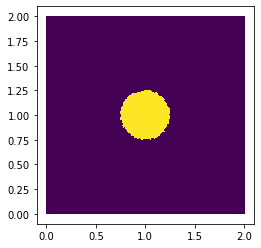

In [5]:
%matplotlib inline

plot(mfunc)

plt.show()

<IPython.core.display.Javascript object>


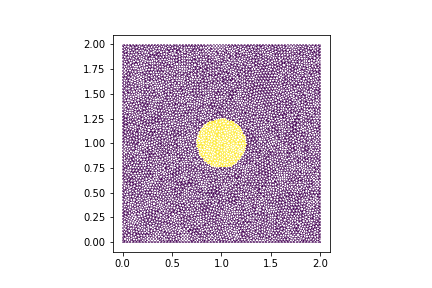

In [4]:
%matplotlib notebook

plot(mfunc_oneliner)
plot(mesh, color='white', lw=0.4)
plt.show()

# 2. Modify the different parameters defining the problem geometry and visualize the results by running the script.
--------------------

## 2. Answer

In [9]:
import numpy as np
import math

# Reference: https://stackoverflow.com/questions/41855695/sorting-list-of-two-dimensional-coordinates-by-clockwise-angle-using-python
origin = [0, 0]
refvec = [0, 1]

def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

In [25]:
np.random.seed(230)
def rand_polygon(npoints):
    xs = np.linspace(0, 2, 11)
    ys = np.linspace(0, 4, 11)
    pts = []
    for pt in range(npoints):
        pt_x, pt_y = np.random.choice(xs), np.random.choice(ys)
        pt_coords = [pt_x, pt_y]
        if pt_coords in pts:
            pt_coords[0] = pt_coords[0]+0.5
        #print(pt_x, pt_y)
        #pts.append(Point(pt_x, pt_y))
        pts.append([pt_x, pt_y])
    mshr_pts = []
    # mshr.Polygon needs the points sorted in the counter clock-wise order
    pts_sorted =sorted(pts, reverse=True, key=clockwiseangle_and_distance)
    for pt in pts_sorted:
        mshr_pts.append(Point(pt))
    return mshr_pts

In [26]:
# i. Geometry definition
Lx = 2
Ly = 4
corner1 = Point(0,0)
corner2 = Point(Lx,Ly)
center = Point(2*Lx/3,Ly/4)
radius = 0.25
domain = Rectangle(corner1, corner2)
domain.set_subdomain(1, Ellipse(center, 0.2, 0.4))
domain.set_subdomain(2, Rectangle(Point(1,3), Point(2,4)))
domain.set_subdomain(3, Polygon(rand_polygon(4)))

class Inclusion(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt ( ( x[0] - Lx/3 ) ** 2 + ( x[1] - Ly/4 ) ** 2 )
        return ( r < radius * 1.001 )

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], 0.0) )

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], Lx) )

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], 0.0) )

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], Ly) )

class Hole(SubDomain):
   def __init__(self,xc,yc,R):
      self.xc = xc
      self.yc = yc
      self.R = R
      SubDomain.__init__(self) # Call base class constructor!
   def inside (self, x, on_boundary ):
      r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
      return ( on_boundary and ( r < self.R * 1.1 ) )

# ii. Mesh generation
subdivisions = 60
mesh = generate_mesh ( domain, subdivisions )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

# iii. Mark subdomains
mfunc = MeshFunction("size_t", mesh, mesh.topology().dim())
mfunc.set_all(1)
inclusion = Inclusion()
inclusion.mark(mfunc, 2)


    |-Mesh done
    |--Number of vertices = 4582
    |--Number of cells = 8896
    |--Cell size hmax,hmin = 0.0671 0.0118


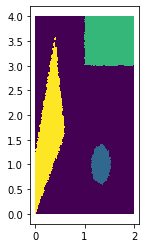

In [27]:
%matplotlib inline
mfunc_oneliner = MeshFunction('size_t', mesh, 2, mesh.domains())
plot(mfunc_oneliner)

plt.show()

# 3. Survey the meaning of the argument subdivisions related to the mesh refinement during grid generation: 
````mesh = generate_mesh ( domain , subdivisions )````

[A good source of information is the Fenics git repository where Fenics’ source files are available](https://bitbucket.org/%7B795b0eed-436d-4242-83d7-a46a0b061354%7D/)

------------

## 3. Answer

The subdivisions argument of the `generate_mesh()` function is used as a refinement parameter. According to the `MeshGenerator.cpp` file in the `mshr` repository, the `resolution` parameter (here named `subdivisions`) is used to define the `segment_granularity`, which is a double, and the `cell_size`, as two times the `bounding_circle` (radius of the circle that inscribes the geometry) divided by the `resolution`.

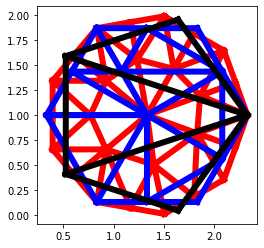

In [75]:
domain = Circle(center, 1)
c = ['k', 'b', 'r', 'g']
for i, sub in enumerate([1, 2, 3]):
    mesh = generate_mesh(domain, sub)
    plot(mesh, color=c[i], lw=6, zorder=4-i)

# 4. Consider the following instructions that allow us to mark a set of elements of the current mesh for further refinement:

``cell_markers = MeshFunction (" bool ", mesh , mesh . topology () . dim () )
cell_markers . set_all ( False )
for cell in cells ( mesh ) :
if( mfunc [ cell ] == 2) :
cell_markers [ cell ] = True
mesh = refine ( mesh , cell_markers )
``

Implement and visualize the results.

-----------

## 4. Answer

In [104]:
# i. Geometry definition
Lx = 2
Ly = 4
corner1 = Point(0,0)
corner2 = Point(Lx,Ly)
center = Point(2*Lx/3,Ly/4)
radius = 0.25
domain = Rectangle(corner1, corner2)
domain.set_subdomain(1, Ellipse(center, 0.2, 0.4))
domain.set_subdomain(2, Rectangle(Point(1,3), Point(2,4)))
#domain.set_subdomain(3, Polygon(rand_polygon(4)))

class Inclusion(SubDomain):
    def inside(self, x, on_boundary):
        r = sqrt ( ( x[0] - Lx/3 ) ** 2 + ( x[1] - Ly/4 ) ** 2 )
        return ( r < radius * 1.001 )

class Left(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], 0.0) )

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], Lx) )

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], 0.0) )

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], Ly) )

class Hole(SubDomain):
   def __init__(self,xc,yc,R):
      self.xc = xc
      self.yc = yc
      self.R = R
      SubDomain.__init__(self) # Call base class constructor!
   def inside (self, x, on_boundary ):
      r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
      return ( on_boundary and ( r < self.R * 1.1 ) )

# ii. Mesh generation
subdivisions = 20
mesh = generate_mesh ( domain, subdivisions )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

# iii. Mark subdomains
mfunc = MeshFunction("size_t", mesh, mesh.topology().dim())
mfunc.set_all(1)
inclusion = Inclusion()
inclusion.mark(mfunc, 2)
mfunc_oneliner = MeshFunction('size_t', mesh, 2, mesh.domains())


cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
cell_markers.set_all(False)
for cell in cells(mesh):
    if (mfunc_oneliner [cell] == 1) + (mfunc_oneliner[cell] == 2) :
        cell_markers [cell] = True
mesh = refine(mesh, cell_markers)

    |-Mesh done
    |--Number of vertices = 526
    |--Number of cells = 960
    |--Cell size hmax,hmin = 0.2 0.108


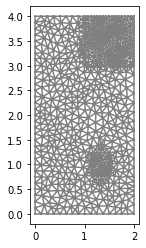

In [105]:
plot(mesh)

# 5. Apply the different geometrical transformations available (scaling and rotation) in the script.

-----------------

## 5. Answer

    |--Cell size hmax,hmin = 0.8 0.169


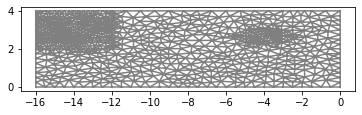

In [106]:
# iv. Mesh transformations
scale = 1
if(scale):
    # Scale the coordinates
    x = mesh.coordinates()
    x[:,0] = x[:,0]*2
    x[:,1] = x[:,1]*4
    print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))
    
angle = 90
if(angle):
    # Rotate with respect to z-axis
    mesh.rotate(angle, 2, corner1)

plot(mesh)

# 6. In the Fluid Problem section the incompressible Stokes’ equations for viscous flows are being solved on a new domain which is made of a rectangular region with a circular hole.

Next, the mathematical and finite element formulations are given, however, it is not expected at
this point the student will fully understand all the details, the necessary mathematical tools will
appear in future lectures.

Given the computational domain $\Omega \subset \mathbb{R}^{d}(d=2 \text { or } 3), \partial \Omega=\Gamma_{\text { inlet }} \cup \Gamma_{\text { wall }} \cup \Gamma_{\text { outlet }}$ , body force $f$ and fluid viscosity $\mu$, find velocity field $\mathbf{u}$ and pressure field $p$ satisfying:

$$ \left\{\begin{array}{ll}{-\nabla \cdot\left(2 \mu \nabla^{S} \mathbf{u}\right)+\nabla p=\mathbf{f}} & {\text { in } \Omega} \\ {\nabla \cdot \mathbf{u}=0} & {\text { in } \Omega} \\ {\mathbf{u}=\mathbf{u}_{\text { inlet }}} & {\text { on } \Gamma_{\text { inlet }}} \\ {\mathbf{u}=0} & {\text { on } \Gamma_{\text { wall }}} \\ {\boldsymbol{\sigma} \cdot \mathbf{n}=0} & {\text { on } \Gamma_{\text { oatlet }}}\end{array}\right. $$

The discrete finite element formulation uses the Taylor–Hood element. The velocity field is sought in a finite dimensional space Vh of quadratic functions and the pressure field is sought in a finite dimensional space Qh of linear functions.

The variational formulation reads:
" Find $\mathbf{u}_{h} \in V_{h}$ and $p_{h} \in Q_{h}$, such that:

$$\int_{\Omega} \mu\left(\nabla \mathbf{u}_{h}+\nabla \mathbf{u}_{h}^{\top}\right) : \nabla \mathbf{v}_{h} d x-\int_{\Omega} p_{h} \nabla \cdot \mathbf{v}_{h} d x+\int_{\Omega} q_{h} \nabla \cdot \mathbf{u}_{h} d x=\int_{\Omega} \mathbf{f} \cdot \mathbf{v}_{h} d x$$

forall $\left(\mathbf{v}_{h}, q_{h}\right) \in V_{h 0} \times Q_{h}^{\prime \prime}$

Compare with:

``# Variational problem
(u, p) = TrialFunctions(W)
(v, q) = TestFunctions(W)
mu = Constant(1)
a = (inner(2*mu*sym(grad(u)), grad(v)) - div(v)*p + q*div(u))*dx
f = Constant((0, 0))
L = inner(f, v)*dx
``

Now, consider the following instructions:

``
boundaries = MeshFunction (" size_t ", mesh , mesh.topology ().dim () -1)
boundaries.set_all (0)
inlet.mark ( boundaries , 1)
outlet.mark ( boundaries , 3)
ds = Measure ("ds") ( subdomain_data = boundaries )
n = FacetNormal ( mesh )
Qin = assemble ( dot (u , n ) * ds (1) )
Qout = assemble ( dot (u , n ) * ds (3) )
print ( Qin , Qout )
``

Try to guess what is being done (in mathematical terms) and interpret the results.

------------------------

## 6. Answer
The MeshFunction is used to mark all the boundaries. inlet and outlet are marked as 1 and 3. It is created a new measure that considers the marked boundaries. It is also created a normal vector using FacetNormal. Finally, the new measure and the normal vector are used to calculate the flux on the boundaries integrating the dot product of the velocity with the normal vector over the boundary.

# 7. Implement a version of the script that works irrespective of the space dimension, i.e., 2D or 3D. (Changes to the current version of the program should be minimal).

-----------------------

## 7. Answer

In [129]:
from dolfin import *
from mshr import *
import os

dimension = 3

# i. Geometry definition
Lx = 2
Ly = 2
Lz = 2
if dimension == 2:
    corner1 = Point(0,0)
    corner2 = Point(Lx,Ly)
    center = Point(Lx/2,Ly/2)
    radius = 0.25
    domain = Rectangle(corner1, corner2)
    domain.set_subdomain(1, Circle(center,radius))

elif dimension == 3:
    corner1 = Point(0, 0, 0)
    corner2 = Point(Lx, Ly, Lz)
    center = Point(Lx/2, Ly/2, Lz/2)
    radius = 0.25
    domain = Box(corner1, corner2)
    #domain.set_subdomain(1, Sphere(center,radius))

if dimension == 2:
    class Inclusion(SubDomain):
        def inside(self, x, on_boundary):
            r = sqrt ( ( x[0] - Lx/2 ) ** 2 + ( x[1] - Ly/2 ) ** 2 )
            return ( r < radius * 1.001 )
        
if dimension == 3:
    class Inclusion(SubDomain):
        def inside(self, x, on_boundary):
            r = sqrt ( ( x[0] - Lx/2 ) ** 2 + ( x[1] - Ly/2 ) ** 2 + ( x[2] - Lz/2 ) ** 2)
            return ( r < radius * 1.0001 )
        
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], 0.0) )

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[0], Lx) )

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], 0.0) )

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return ( on_boundary and near(x[1], Ly) )

if dimension == 3:
    class Front(SubDomain):
        def inside(self, x, on_boundary):
            return ( on_boundary and near(x[2], 0.0) )

    class Back(SubDomain):
        def inside(self, x, on_boundary):
            return ( on_boundary and near(x[2], Lz) )
        
class Hole(SubDomain):
   def __init__(self,xc,yc,R):
      self.xc = xc
      self.yc = yc
      self.R = R
      SubDomain.__init__(self) # Call base class constructor!
   def inside (self, x, on_boundary ):
      r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 )
      return ( on_boundary and ( r < self.R * 1.1 ) )

# ii. Mesh generation
subdivisions = 80
mesh = generate_mesh ( domain, subdivisions )
print("    |-Mesh done")
print("    |--Number of vertices = "+str(mesh.num_vertices()))
print("    |--Number of cells = "+str(mesh.num_cells()))
print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

# iii. Mark subdomains
mfunc = MeshFunction("size_t", mesh, mesh.topology().dim())
mfunc.set_all(1)
inclusion = Inclusion()
inclusion.mark(mfunc, 2)

    |-Mesh done
    |--Number of vertices = 74753
    |--Number of cells = 441963
    |--Cell size hmax,hmin = 0.0864 0.0374


In [130]:
dir_ = './results'
if not os.path.exists(dir_):
    os.mkdir(dir_)
file_pvd  = File(dir_+"/res.pvd")
file_pvd << mfunc

**Note: The use of Subdomains is only supported in 2D**

In [140]:
# iv. Mesh transformations
scale = 0
if(scale):
    # Scale the coordinates
    x = mesh.coordinates()
    x[:,0] = x[:,0]*2
    x[:,1] = x[:,1]*4
    print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))
    
angle = 0
if(angle):
    # Rotate with respect to z-axis
    mesh.rotate(angle, 2, corner1)

# Save results for visulation in Paraview
dir_ = './results'
if not os.path.exists(dir_):
    os.mkdir(dir_)
file_pvd  = File(dir_+"/res.pvd")
file_pvd << mfunc

# v. Inspect the mesh
inspect = 0
if(inspect):    
    # Incidencies
    elems = cells(mesh)
    print("Element to node")
    for e in elems:
        incids = []
        for v in vertices(e):
            incids.append(v.index())
            
        print(e.index(), incids, e.circumradius())
            
    # Incidencies transpose
    print("Node to element")
    for v in vertices(mesh):
        conec = []
        for c in cells(v):
            conec.append(c.index())
            
        print (v.index(), conec)
    
if dimension == 3:
    class Hole(SubDomain):
       def __init__(self,xc,yc,zc,R):
          self.xc = xc
          self.yc = yc
          self.zc = zc
          self.R = R
          SubDomain.__init__(self) # Call base class constructor!
       def inside (self, x, on_boundary ):
          r = sqrt ( ( x[0] - self.xc ) ** 2 + ( x[1] - self.yc ) ** 2 + ( x[2] - self.zc ) ** 2)
          return ( on_boundary and ( r < self.R * 1.1 ) )
# vi. Fluid Problem
fluid_problem = 1
if(fluid_problem): # Begin Stokes problem

    # New geometry: Rectangle with a hole
    centerhole = Point(Lx/4,Ly/4, Lz/4)
    domain = Box(corner1, corner2)
    domain = domain - Sphere(centerhole, radius)
    subdivisions = 20
    mesh = generate_mesh (domain, subdivisions)
    
    # Finite element spaces
    P2 = VectorElement("Lagrange", 'tetrahedron', 2)
    P1 = FiniteElement("Lagrange", 'tetrahedron', 1)
    TH = P2 * P1
    W = FunctionSpace(mesh, TH)

    # Define subdomain classes associated to boundaries
    inlet = Left()
    top = Top()
    outlet = Right()
    bottom = Bottom()
    back = Back()
    front = Front()
    hole = Hole(Lx/4,Ly/4, Lz/4,0.5*radius)

    # Boundary conditions
    # Inlet
    if dimension == 2:
        inflow = Expression(("sin(x[1]*pi/2)", "0.0"), degree=2)
        noslip = Constant((0, 0))
    elif dimension ==  3:
        inflow = Expression(("sin(x[1]*pi/2)", "0.0", "0.0"), degree=2)
        noslip = Constant((0, 0, 0))

    bcIn  = DirichletBC(W.sub(0), inflow, inlet)
    # No-slip (walls= top, bottom and hole)
    
    bcnsb  = DirichletBC(W.sub(0), noslip, bottom)
    bcnst  = DirichletBC(W.sub(0), noslip, top)
    bchole = DirichletBC(W.sub(0), noslip, hole)
    bcfront = DirichletBC(W.sub(0), noslip, front)
    bcback = DirichletBC(W.sub(0), noslip, back)

    
    # Variational problem
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)
    mu = Constant(1)
    a = (inner(2*mu*sym(grad(u)), grad(v)) - div(v)*p + q*div(u))*dx
    if dimension == 2:
        f = Constant((0, 0))
    elif dimension == 3:
        f = Constant((0, 0, 0))
    L = inner(f, v)*dx

    # Compute solution
    w = Function(W)
    if dimension == 2:
        solve(a == L, w, [bcIn, bcnsb, bcnst, bchole])
    if dimension == 3:
        solve(a == L, w, [bcIn, bcnsb, bcnst, bchole, bcfront, bcback])
   
    # Split the mixed solution using deepcopy
    # (needed for further computation on coefficient vector)
    (u, p) = w.split(True)

    # Mesh function for further integration over boundaries
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    boundaries.set_all(0)
    inlet.mark(boundaries, 1)
    outlet.mark(boundaries, 3)
    ds = Measure("ds")(subdomain_data=boundaries)
    n = FacetNormal(mesh)
    Qin  = assemble(dot(u, n)*ds(1))
    Qout = assemble(dot(u, n)*ds(3))
    print (Qin, Qout)

    # Save results for visulation in Paraview
    u.rename("u","u")
    p.rename("p","p")
    u_pvd  = File(dir_+"/vel.pvd")
    p_pvd  = File(dir_+"/pres.pvd")
    u_pvd << u
    p_pvd << p

-2.452919270277183 2.2296485587224875
